In [1]:
import sys
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("..")
from src.train import load_model
from src.process_graph import process_patent_graph

In [2]:
model = load_model("../src/models/VGAE_d64_0.005")

📂 Loaded model from ../src/models/VGAE_d64_0.005


In [3]:
(
    X,
    A_tilde_train,
    _,
    test_edges,
    _,
    test_non_edges,
) = process_patent_graph(processed_data_dir="../data/ProcessedDatasets/")

📥 Processed data already exists. Loading cached results.


In [4]:
with torch.no_grad():
    Z, _, mu, log_sigma = model(X, A_tilde_train)

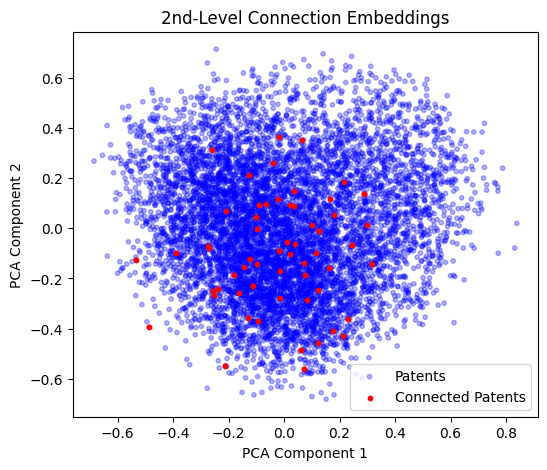

In [11]:
emb_np = Z.cpu().numpy()  # Convert to NumPy array
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(emb_np)  # shape: (num_nodes, 2)


# Identify patents connected to the last CPC node
medium_to_big = (A_tilde_train[10104:10661, 10663] > 0).nonzero(as_tuple=True)[
    0
].cpu().numpy() + 10104
connected_patents = (
    (A_tilde_train[:10104, medium_to_big] > 0).nonzero(as_tuple=True)[0].cpu().numpy()
)


# Visualize the reduced embeddings
num_to_plot = 8000  # e.g., random 500 nodes
all_nodes = np.arange(coords_2d.shape[0])
random_nodes = np.random.choice(all_nodes, size=num_to_plot, replace=False)
coords_subset = coords_2d[random_nodes]
colors = np.full(coords_subset.shape[0], "blue")  # Default color for all nodes
alphas = np.full(coords_subset.shape[0], 0.3)  # Default transparency for blue nodes
connected_mask = np.isin(random_nodes, connected_patents)
colors[connected_mask] = "red"  # Color connected patents in red
alphas[connected_mask] = 1.0  # Make red points fully opaque

plt.figure(figsize=(6, 5))
plt.scatter(
    coords_subset[:, 0], coords_subset[:, 1], c=colors, s=10, alpha=0.3, label="Patents"
)
plt.scatter(
    coords_subset[connected_mask, 0],
    coords_subset[connected_mask, 1],
    c="red",
    s=10,
    alpha=1.0,
    label="Connected Patents",
)
plt.title("2nd-Level Connection Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

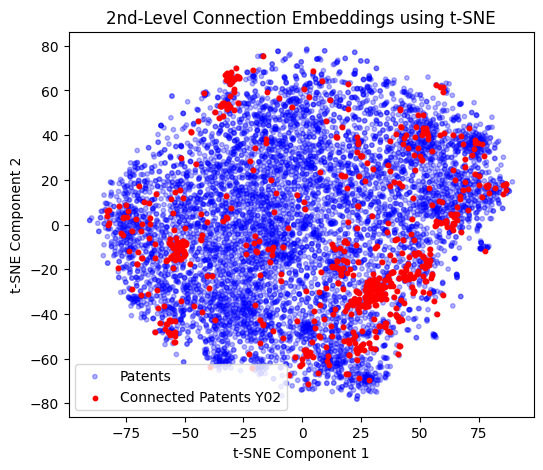

In [28]:
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


# Convert to NumPy array
emb_np = Z.cpu().numpy()  # Convert to NumPy array

# Dimensionality reduction to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords_2d = tsne.fit_transform(emb_np)  # shape: (num_nodes, 2)

# Identify medium CPC nodes connected to the big CPC node
medium_to_big = (A_tilde_train[10104:10661, 10679] > 0).nonzero(as_tuple=True)[
    0
].cpu().numpy() + 10104
connected_patents = (
    (A_tilde_train[:10104, medium_to_big] > 0).nonzero(as_tuple=True)[0].cpu().numpy()
)

# Visualize the reduced embeddings
num_to_plot = 8000  # e.g., random 8000 nodes
all_nodes = np.arange(coords_2d.shape[0])
random_nodes = np.random.choice(all_nodes, size=num_to_plot, replace=False)
coords_subset = coords_2d[random_nodes]

# Determine colors and transparency for the plot
colors = np.full(coords_subset.shape[0], "blue")  # Default color for all nodes
alphas = np.full(coords_subset.shape[0], 0.3)  # Default transparency for blue nodes
connected_mask = np.isin(random_nodes, connected_patents)
colors[connected_mask] = "red"  # Color connected patents in red
alphas[connected_mask] = 1.0  # Make red points fully opaque

plt.figure(figsize=(6, 5))
plt.scatter(
    coords_subset[:, 0], coords_subset[:, 1], c=colors, s=10, alpha=0.3, label="Patents"
)
plt.scatter(
    coords_subset[connected_mask, 0],
    coords_subset[connected_mask, 1],
    c="red",
    s=10,
    alpha=1.0,
    label="Connected Patents Y02",
)
plt.title("2nd-Level Connection Embeddings using t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

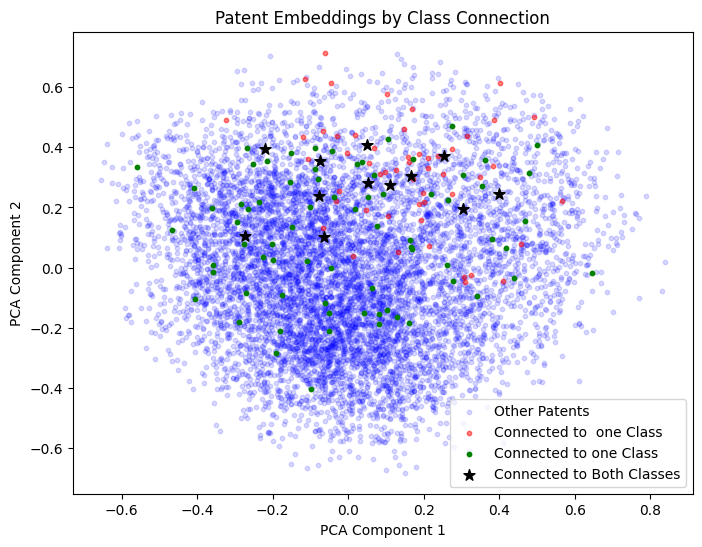

In [65]:
emb_np = Z.cpu().numpy()
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(emb_np)

# Identify patents connected to first major class (10663)
medium_to_big_1 = (A_tilde_train[10104:10661, 10713] > 0).nonzero(as_tuple=True)[
    0
].cpu().numpy() + 10104
connected_patents_1 = (
    (A_tilde_train[:10104, medium_to_big_1] > 0).nonzero(as_tuple=True)[0].cpu().numpy()
)

# Identify patents connected to second major class (10664)
medium_to_big_2 = (A_tilde_train[10104:10661, 10701] > 0).nonzero(as_tuple=True)[
    0
].cpu().numpy() + 10104
connected_patents_2 = (
    (A_tilde_train[:10104, medium_to_big_2] > 0).nonzero(as_tuple=True)[0].cpu().numpy()
)

# Find patents connected to both classes
connected_both = np.intersect1d(connected_patents_1, connected_patents_2)

# Visualize the reduced embeddings
num_to_plot = 8000
all_nodes = np.arange(coords_2d.shape[0])
random_nodes = np.random.choice(all_nodes, size=num_to_plot, replace=False)
coords_subset = coords_2d[random_nodes]

# Create masks for different categories
mask_class1 = np.isin(random_nodes, connected_patents_1)
mask_class2 = np.isin(random_nodes, connected_patents_2)
mask_both = np.isin(random_nodes, connected_both)

# Create separate scatter plots for each category
plt.figure(figsize=(8, 6))

# Plot background points (not connected to either class)
mask_neither = ~(mask_class1 | mask_class2)
plt.scatter(
    coords_subset[mask_neither, 0],
    coords_subset[mask_neither, 1],
    color="blue",
    s=10,
    alpha=0.15,
    label="Other Patents",
)

# Plot points connected to first class only
mask_only_class1 = mask_class1 & ~mask_both
plt.scatter(
    coords_subset[mask_only_class1, 0],
    coords_subset[mask_only_class1, 1],
    color="red",
    s=10,
    alpha=0.5,
    label="Connected to  one Class",
)

# Plot points connected to second class only
mask_only_class2 = mask_class2 & ~mask_both
plt.scatter(
    coords_subset[mask_only_class2, 0],
    coords_subset[mask_only_class2, 1],
    color="green",
    s=10,
    alpha=1,
    label="Connected to one Class",
)

# Plot points connected to both classes
plt.scatter(
    coords_subset[mask_both, 0],
    coords_subset[mask_both, 1],
    color="black",
    marker="*",
    s=70,
    alpha=1,
    label="Connected to Both Classes",
)

plt.title("Patent Embeddings by Class Connection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

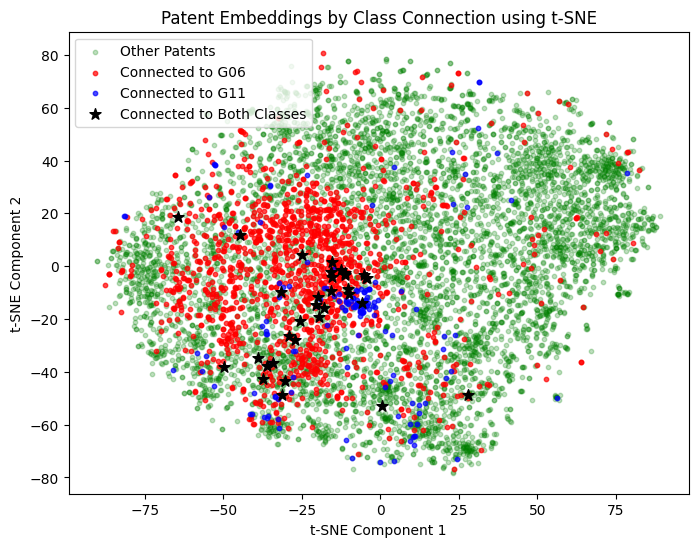

In [56]:
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


# Convert to NumPy array
emb_np = Z.cpu().numpy()  # Convert to NumPy array

# Dimensionality reduction to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords_2d = tsne.fit_transform(emb_np)  # shape: (num_nodes, 2)

# Identify patents connected to first major class
medium_to_big_1 = (A_tilde_train[10104:10661, 10666] > 0).nonzero(as_tuple=True)[
    0
].cpu().numpy() + 10104
connected_patents_1 = (
    (A_tilde_train[:10104, medium_to_big_1] > 0).nonzero(as_tuple=True)[0].cpu().numpy()
)

# Identify patents connected to second major class
medium_to_big_2 = (A_tilde_train[10104:10661, 10693] > 0).nonzero(as_tuple=True)[
    0
].cpu().numpy() + 10104
connected_patents_2 = (
    (A_tilde_train[:10104, medium_to_big_2] > 0).nonzero(as_tuple=True)[0].cpu().numpy()
)

# Find patents connected to both classes
connected_both = np.intersect1d(connected_patents_1, connected_patents_2)

# Visualize the reduced embeddings
num_to_plot = 8000
all_nodes = np.arange(coords_2d.shape[0])
random_nodes = np.random.choice(all_nodes, size=num_to_plot, replace=False)
coords_subset = coords_2d[random_nodes]

# Create masks for different categories
mask_class1 = np.isin(random_nodes, connected_patents_1)
mask_class2 = np.isin(random_nodes, connected_patents_2)
mask_both = np.isin(random_nodes, connected_both)

# Create separate scatter plots for each category
plt.figure(figsize=(8, 6))

# Plot background points (not connected to either class)
mask_neither = ~(mask_class1 | mask_class2)
plt.scatter(
    coords_subset[mask_neither, 0],
    coords_subset[mask_neither, 1],
    color="green",
    s=10,
    alpha=0.25,
    label="Other Patents",
)

# Plot points connected to first class only
mask_only_class1 = mask_class1 & ~mask_both
plt.scatter(
    coords_subset[mask_only_class1, 0],
    coords_subset[mask_only_class1, 1],
    color="red",
    s=10,
    alpha=0.7,
    label="Connected to G06",
)

# Plot points connected to second class only
mask_only_class2 = mask_class2 & ~mask_both
plt.scatter(
    coords_subset[mask_only_class2, 0],
    coords_subset[mask_only_class2, 1],
    color="blue",
    s=10,
    alpha=0.7,
    label="Connected to G11",
)

# Plot points connected to both classes
plt.scatter(
    coords_subset[mask_both, 0],
    coords_subset[mask_both, 1],
    color="black",
    marker="*",
    s=70,
    alpha=1,
    label="Connected to Both Classes",
)

plt.title("Patent Embeddings by Class Connection using t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()